In [1]:
import pdb
import numpy as np
import pandas as pd
import networkx as nx
import wntr
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

from ML_for_WDN.data_utils import clean_dataframes, load_data

from ML_for_WDN.models import UnsupervisedLeakDetector

# set working directory to root directory
%cd ..

torch.set_default_dtype(torch.float32)


DATA_FILES_TRAIN = [
    'data/data_no_leak.xlsx',
]

DATA_FILES_TEST = [
    'data/data_leak_1.xlsx',
    'data/data_leak_2.xlsx',
    'data/data_leak_3.xlsx',
]

columns_to_use = [
    'FM01_flow', 'FM02_flow', 'FM03_flow', 'FM05_flow', 'FM06_flow', 'FM08_flow', 'FM09_flow', 'FM11_flow', 'FM13_flow',
    'FM01_head', 'FM02_head', 'FM03_head', 'FM05_head', 'FM06_head', 'FM08_head', 'FM09_head', 'FM11_head', 'FM13_head',
]

# Train data
dataframes = []
for data_file in DATA_FILES_TRAIN:
    df = load_data(data_file)
    dataframes.append(df)

dataframes = clean_dataframes(
    dataframes,
    columns_to_use=columns_to_use,
)
X_train = dataframes[0]

X_test = X_train.iloc[-5000:, :]
X_train = X_train.iloc[:-5000, :]

X_train = X_train.values

# Test data
dataframes = []
for data_file in DATA_FILES_TEST:
    df = load_data(data_file)
    dataframes.append(df)

dataframes = clean_dataframes(
    dataframes,
    columns_to_use=columns_to_use,
)
dataframes = pd.concat(dataframes, ignore_index=True)

X_test = pd.concat([X_test, dataframes], ignore_index=True)
X_test = X_test.values

y_test = np.zeros((X_test.shape[0]))
y_test[0:5000] = 1
y_test[5000:] = -1


/export/scratch1/ntm/nikolaj_workstation_data/PhD/ML-for-WDN


In [5]:

LATENT_DIM = 4

NN_args = {
    'encoder_args': {
        'hidden_dims': [16, 12, 8],
        'latent_dim': LATENT_DIM,
    },
    'decoder_args': {
        'latent_dim': LATENT_DIM,
        'hidden_dims': [8, 12, 16],
    },
    'NN_train_args': {
        'epochs': 1000,
        'batch_size': 512,
        'lr': 5e-3,
        'weight_decay': 1e-4,
        'loss_fn': nn.MSELoss(),
        'supervised_pars': None,
    },
    'anomaly_detection_args': {},
    'device': 'cpu',
}

model_list = [
    UnsupervisedLeakDetector(**NN_args),
]


########## Training stage 1 ##########


Training autoencoder without leak data


Autoencoder architecture:
- Latent dimension: 4
- Encoder hidden dimensions: [16, 12, 8]
- Decoder hidden dimensions: [8, 12, 16]




  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.4113 | Latent: 1.4647: 100%|██████████| 1000/1000 [02:45<00:00,  6.04it/s]




Autoencoder training complete


########## Training stage 2 ##########


Training anomaly detector using autoencoder


Anomaly detector training complete


Accuracy: 0.943
Recall: 0.2056
Precision: 0.40361209265802905


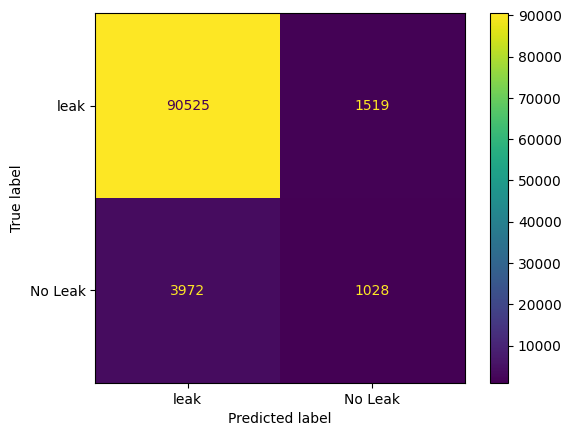

In [7]:
for model in model_list:
    pipeline = Pipeline([
        ('scaler',  StandardScaler()),
        ('model', model),
    ])

    pipeline.fit(
        X=X_train,
    )

    preds = pipeline.predict(
        X=X_test,
    )
    
    cm = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds):0.3f}')
    print(f'Recall: {cm[1,1]/(cm[1,1]+cm[1,0])}')
    print(f'Precision: {cm[1,1]/(cm[1,1]+cm[0,1])}')
        
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['leak', 'No Leak'],
    )
    disp.plot()
    plt.show()
